# Using the latest advancements in AI to predict stock market movements
https://github.com/borisbanushev/stockpredictionai

In [1]:
%%capture
!pip install -r requirements.txt

In [2]:
import helper
import pandas as pd
from utils import *

import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)

In [3]:
dataset_ex_df = pd.read_csv('data/GS.csv', header=0, parse_dates=[0], date_parser=helper.date_parser)

In [4]:
dataset_ex_df[['Date', 'Close']].head()

,Date,Close
0,2009-12-31,168.839996
1,2010-01-04,173.080002
2,2010-01-05,176.139999
3,2010-01-06,174.259995
4,2010-01-07,177.669998


In [5]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 2265 number of days in the dataset.


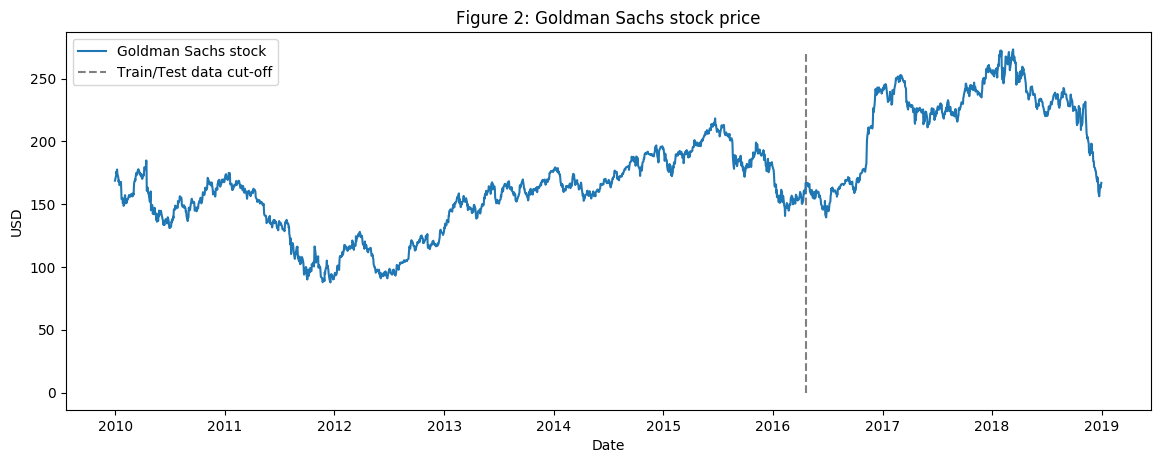

In [6]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['Close'], label='Goldman Sachs stock')
plt.vlines(datetime.date(2016,4, 20), 0, 270, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('Figure 2: Goldman Sachs stock price')
plt.legend()
plt.show()


In [7]:
num_training_days = int(dataset_ex_df.shape[0]*.7)
num_test_days = dataset_ex_df.shape[0]-num_training_days
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, num_test_days))

Number of training days: 1585. Number of test days: 680.


In [8]:
dataset_TI_df = helper.get_technical_indicators(dataset_ex_df, "Close")
dataset_TI_df = dataset_TI_df[20:]
dataset_TI_df.reset_index(drop=True, inplace=True)
dataset_TI_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
0,2010-02-01,149.820007,155.250000,149.210007,153.130005,130.870697,12980800,152.374285,164.220476,160.321839,156.655072,-3.666767,9.607375,183.435226,145.005726,152.113609,152.130005,5.024735
1,2010-02-02,153.649994,157.500000,153.649994,156.940002,134.126846,17246600,152.777143,163.653809,160.014868,156.700047,-3.314821,9.480630,182.615070,144.692549,155.331204,155.940002,5.049471
2,2010-02-03,157.919998,159.940002,157.110001,157.229996,134.374695,16785200,153.098572,162.899047,159.766235,156.783365,-2.982871,9.053702,181.006450,144.791644,156.597065,156.229996,5.051329
3,2010-02-04,155.270004,156.059998,150.449997,150.679993,128.776871,18895000,153.069999,161.686666,158.967168,155.827031,-3.140137,8.940246,179.567158,143.806174,152.652350,149.679993,5.008500
4,2010-02-05,150.820007,154.460007,148.869995,154.160004,131.750992,18759200,153.449999,160.729523,158.550196,155.566566,-2.983631,8.151912,177.033348,144.425699,153.657453,153.160004,5.031483


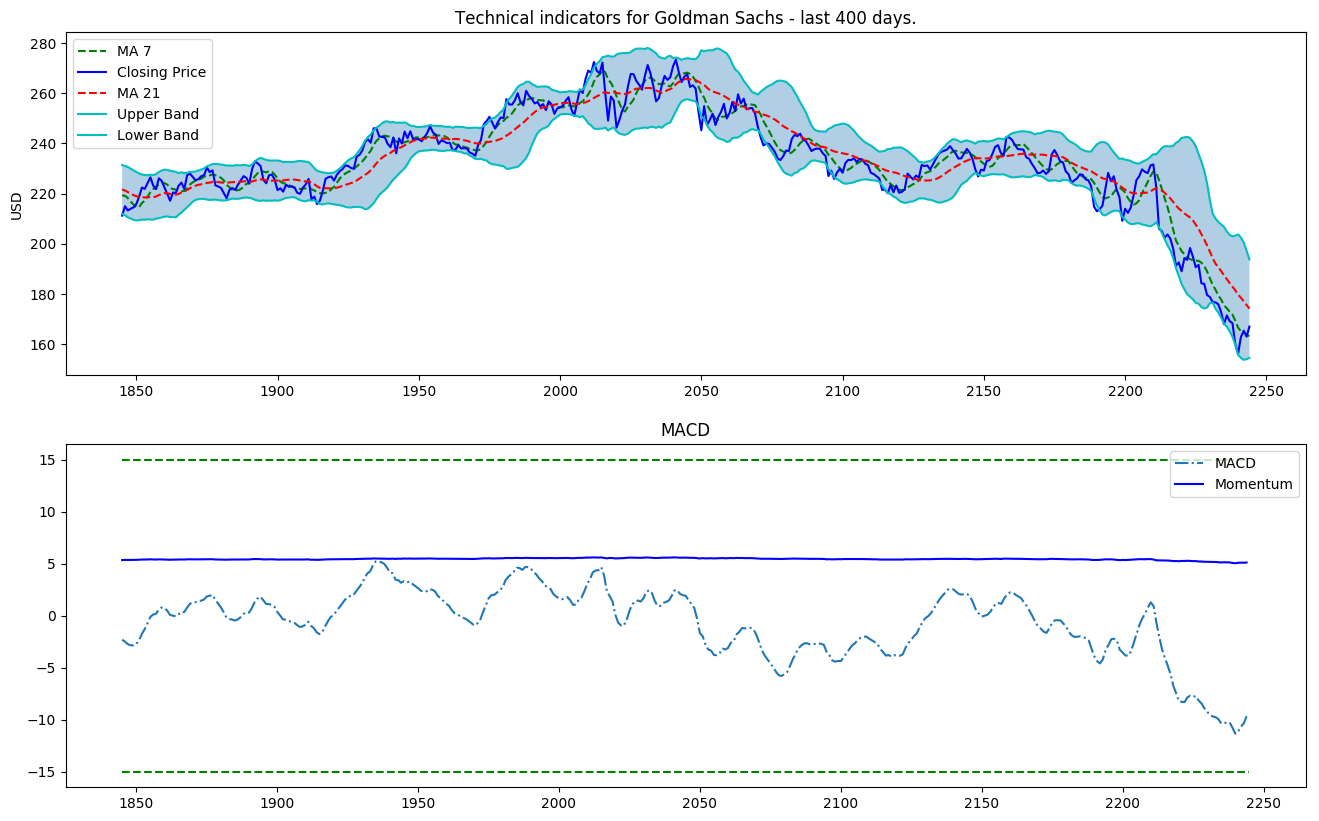

In [9]:
helper.plot_technical_indicators(dataset_TI_df, 400)

In [10]:
data_FT = dataset_ex_df[['Date', 'Close']]

In [11]:
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

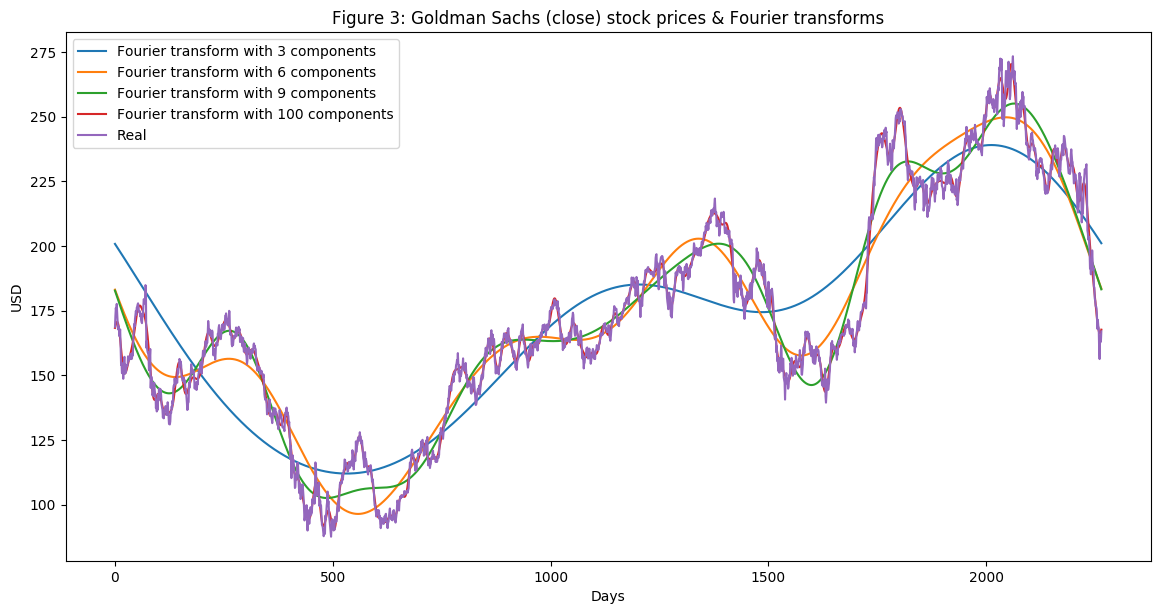

In [12]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

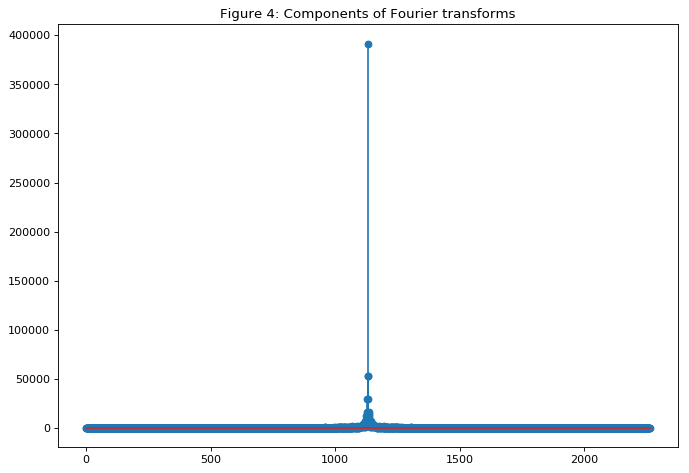

In [13]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

In [14]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2264
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -5465.888
Method:                       css-mle   S.D. of innovations              2.706
Date:                Mon, 23 Nov 2020   AIC                          10945.777
Time:                        02:40:32   BIC                          10985.851
Sample:                             1   HQIC                         10960.399
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0011      0.054     -0.020      0.984      -0.106       0.104
ar.L1.D.Close    -0.0205      0.021     -0.974      0.330      -0.062       0.021
ar.L2.D.Close     0.0140      0.021     

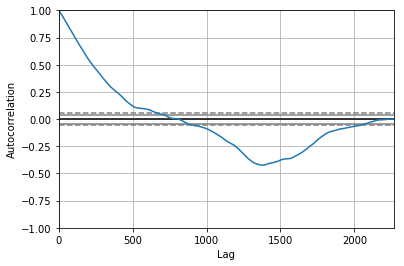

<Figure size 800x560 with 0 Axes>

In [15]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [16]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [17]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 10.151


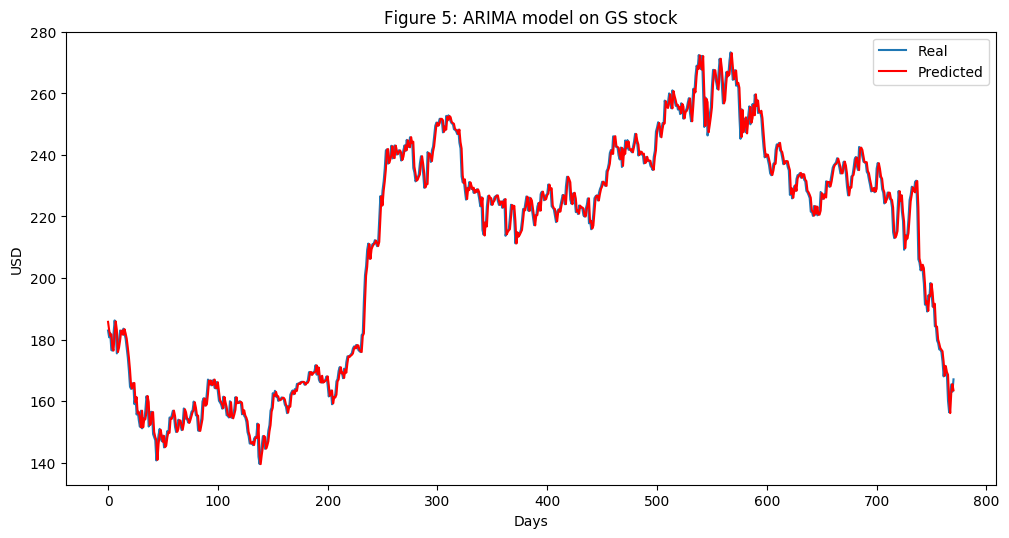

In [18]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

Expected Features: 112

- Stock History: 1
    - Close
- Correlated assets: 72
- Technical indicators: 11
    - Moving Average: 2
        - 7 Days
        - 21 Days
    - Moving Average Convergence Divergence: 3
        - 26 Days
        - 12 Days
        - MACD
    - Bollinger Bands: 3
        - 20 Days Standard Deviation
        - Upper Band
        - Lower Band
    - Exponential Moving Average: 1
    - Momentum: 2
        - Momentum
        - Log Momentum
- Fundamental analysis: 1
- Fourier transforms: 36
    - FFT 3: 6
    - FFT 6: 12
    - FFT 9: 18
- AutoRegressive Integrated Moving Average: 1

In [19]:
# TODO: dataset_total_df is not found
# dataset_total_df is undefined
# print('Total dataset has {} samples, and {} features.'.format(dataset_total_df.shape[0], dataset_total_df.shape[1]))

In [20]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = helper.get_feature_importance_data(dataset_TI_df)

In [21]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [22]:
eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)]
xgbModel = regressor.fit(X_train_FI,y_train_FI, eval_set=eval_set, verbose=False)

In [23]:
eval_result = regressor.evals_result()

In [24]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

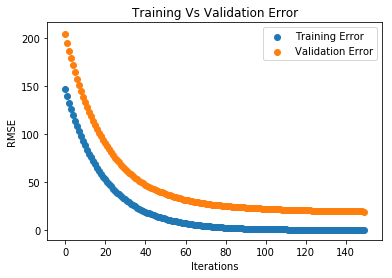

In [25]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

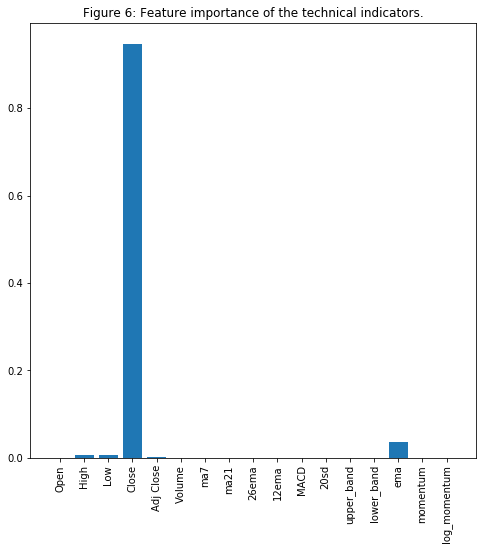

In [26]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

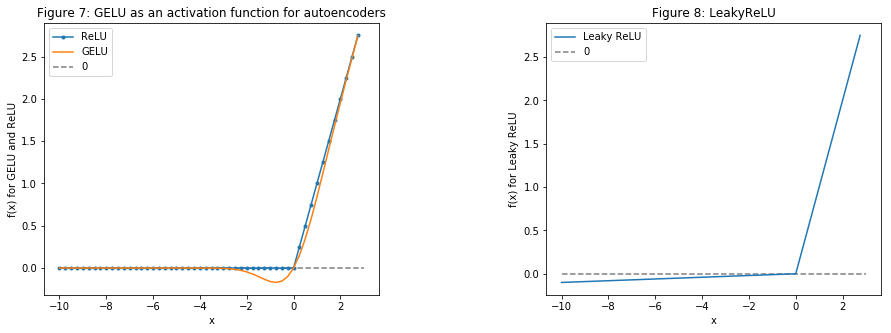

In [27]:
plt.figure(figsize=(15, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.5, hspace=None)

ranges_ = (-10, 3, .25)

plt.subplot(1, 2, 1)
plt.plot([i for i in np.arange(*ranges_)], [helper.relu(i) for i in np.arange(*ranges_)], label='ReLU', marker='.')
plt.plot([i for i in np.arange(*ranges_)], [helper.gelu(i) for i in np.arange(*ranges_)], label='GELU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.title('Figure 7: GELU as an activation function for autoencoders')
plt.ylabel('f(x) for GELU and ReLU')
plt.xlabel('x')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot([i for i in np.arange(*ranges_)], [helper.lrelu(i) for i in np.arange(*ranges_)], label='Leaky ReLU')
plt.hlines(0, -10, 3, colors='gray', linestyles='--', label='0')
plt.ylabel('f(x) for Leaky ReLU')
plt.xlabel('x')
plt.title('Figure 8: LeakyReLU')
plt.legend()

plt.show()